# Data Acquisition
This is the notebook whereby I obtain the labeled image set that will be for this project. I will use several geographic datasets covering the Denver metro area to create the API requests against the Google StreetView static API. 
Because of licensing on the API, I am not able to making the images availible, but if you obtain a deverloper key you can use this notebook to download a similar dataset.

In [59]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.ops import nearest_points
from shapely.geometry import Point, LinearRing
import matplotlib.pyplot as plt
import seaborn as sns
import random
from os import path
import urllib.request
import requests
import pickle
from math import atan2, degrees, pi
import pyproj
from tqdm import tqdm
import urllib, os, json

In [2]:
down_loc = os.getcwd()
down_loc

'C:\\Users\\User\\Documents\\GitHub\\sidewalks_deep-learning'

Outline: 
* data sourcing
    * set up google api to download images
    * generate random lat, long
    * test location for being in urban area covered by map
    * use street view to find nearest image
    * get image metadata inc lat lon & direction
    * see if there is sidewalk centerline w/in 10ft?, create label in dataframe
* modeling
    * create tf model to classify images, train/test/validate
* use pretrained model to do object detection of sidewalks
* cluster sidewalks by type
    

In [3]:
pwd

'C:\\Users\\User\\Documents\\GitHub\\sidewalks_deep-learning'

In [4]:
#download data sources if not there
data_urls = {}
data_urls['sidewalk_extent'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_extent_centerline_sidewalks&outputFormat=application%2Fjson'
data_urls['sidewalk_centerlines'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_centerline_sidewalks&outputFormat=application%2Fjson'
#data_urls['road_borders'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_eop_line&outputFormat=application%2Fjson'
data_urls['road_polygons'] = r'https://gis.drcog.org/geoserver/DRCOGPUB/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=DRCOGPUB:planimetrics_2016_eop_poly&outputFormat=application%2Fjson'
for key, value in data_urls.items():
    if not path.exists(key + ".geojson"):
        urllib.request.urlretrieve(value, key + '.geojson')

In [5]:
sidewalk_gdf = gpd.read_file('sidewalk_centerlines.geojson')
sidewalk_extent_gdf = gpd.read_file('sidewalk_extent.geojson')
road_polygons_gdf = gpd.read_file('road_polygons.geojson')

In [6]:
sidewalk_gdf.head()

,id,gid,createdate,createuser,type,comments,update_sta,unique_id,geometry
0,planimetrics_2016_centerline_sidewalks.534414,534414,2016-04-08,Kucera,Sidewalk,None,N,534414,"MULTILINESTRING ((3096575.759 1779104.505, 309..."
1,planimetrics_2016_centerline_sidewalks.534415,534415,2016-04-08,Kucera,Sidewalk,None,N,534415,"MULTILINESTRING ((3095429.059 1779035.067, 309..."
2,planimetrics_2016_centerline_sidewalks.534416,534416,2016-04-08,Kucera,Other crossing,None,N,534416,"MULTILINESTRING ((3096759.611 1779106.863, 309..."
3,planimetrics_2016_centerline_sidewalks.534417,534417,2016-04-08,Kucera,Sidewalk,None,N,534417,"MULTILINESTRING ((3096821.734 1779106.976, 309..."
4,planimetrics_2016_centerline_sidewalks.534418,534418,2016-04-08,Kucera,Sidewalk,None,N,534418,"MULTILINESTRING ((3096759.611 1779106.863, 309..."


In [7]:
sidewalk_extent_gdf.head()

,id,gid,sqmi,geometry
0,planimetrics_2016_extent_centerline_sidewalks.1,1,1378.109985,"MULTIPOLYGON (((3138537.128 1894378.599, 31385..."


In [8]:
road_polygons_gdf.head()

,id,gid,createdate,createuser,surface,type,comments,update_sta,unique_id,geometry
0,planimetrics_2016_eop_poly.1,1,2015-07-08,Kucera,Paved,Corridor,None,M,1,"MULTIPOLYGON (((3178008.528 1680396.903, 31780..."
1,planimetrics_2016_eop_poly.2,2,2015-07-08,Kucera,Paved,Corridor,None,M,2,"MULTIPOLYGON (((3177083.131 1680684.331, 31770..."
2,planimetrics_2016_eop_poly.3,3,2015-07-08,Kucera,Paved,Corridor,None,M,3,"MULTIPOLYGON (((3175748.021 1679192.504, 31757..."
3,planimetrics_2016_eop_poly.4,4,2015-07-08,Kucera,Paved,Corridor,None,M,4,"MULTIPOLYGON (((3171378.719 1680722.643, 31714..."
4,planimetrics_2016_eop_poly.5,5,2015-07-08,Kucera,Paved,Corridor,None,M,5,"MULTIPOLYGON (((3171676.961 1684022.116, 31716..."


### check/fix geometry projection

In [9]:
total_bounds = sidewalk_gdf.geometry.total_bounds
total_bounds

array([2935159.7025    , 1508775.0615    , 3411162.9985    ,
       1980230.98999999])

In [10]:
sidewalk_extent_gdf.geometry.total_bounds

array([2932503.25159384, 1503238.87488092, 3414549.89051701,
       1991021.48166284])

desired bounds: 39-41; - 104-106. These are standard *WGS84* AKA *EPSG 4326*

In [11]:
sidewalk_extent_gdf.geometry.crs

{'init': 'epsg:6428'}

In [12]:
road_polygons_gdf = road_polygons_gdf.to_crs(epsg=4326)

In [13]:
sidewalk_gdf = sidewalk_gdf.to_crs(epsg=4326)
sidewalk_gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

In [14]:
sidewalk_extent_gdf = sidewalk_extent_gdf.to_crs(epsg=4326)
print(f'sidewalk extent crs:{sidewalk_extent_gdf.geometry.crs} \nexample coordinates {sidewalk_extent_gdf.geometry.centroid}')

sidewalk extent crs:{'init': 'epsg:4326', 'no_defs': True} 
example coordinates 0    POINT (-104.97145 39.80632)
dtype: geometry


### Latitude & Longitude:
Coordinates for sidewalk data set are in *Longitude*, **Latitude** format. 
Google Streetview API takes **Latitude**, *Longitude* format.

# Find Points and Download Images

# Image Downloading Class

In [354]:
class image_grabber(object):
    '''
    Creates random points and tests for appropriateness for image downloading. 
    Generates heading for appropriate points. 
    Downloads images from google maps api based on generated coordinates & heading. 
    Args:
        sidewalks: sidewalk outline geodataframe
        sidewalk_polygon: outline of area surveyd for sidewalks
        road_polygons: outline of roads (so image capture direction can be toward sidewalks)
        lines: duplicate?
        direc: where images get saved
        distance_to_sidewalk: meters along heading to look for sidewalk line
    Attributes:
        confirmed_locations = created by .generate_numbers() method. contains list of [Heading, [shapely.Point]] items
        locations_w_label = created by .get_labels() method. has list of [Heading, [lat, lon], label] items
        met_lis: list items are [date, panoID, filename]
    Example Usage:
        image_grab = image_grabber()
        image_grab.generate_numbers(1)
        image_grab.download_images()
    TODO: 
        get working! image directions not greate and labels are only showing 'sidewalk'
        Fix excess use of self.* naming
        remove extra print statements
    '''
    def __init__(self, sidewalks=sidewalk_gdf, sidewalk_polygon=sidewalk_extent_gdf.geometry, 
                 road_polygons=road_polygons_gdf, 
                 direc=os.path.join(os.getcwd(), "images"), distance_to_sidewalk=12,
                img_dim=(800,800), fov=90, radius=100):
        self.sidewalks = sidewalks
        self.sidewalk_polygon = sidewalk_polygon
        self.road_polygons = road_polygons
        #self.road_polygon['rep_points'] = self.road_polygon.geometry.apply(lambda obj: obj.representative_point()) # for closest ob finder
        self.confirmed_locations = []
        self.locations_w_label = []
        self.metadata_url = ""
        self.direc = direc
        self.geod = pyproj.Geod(ellps='WGS84') #standard projection
        self.image_list = []
        self.PrevImage = []
        self.dist_to_sdwlk = distance_to_sidewalk
        self.url_list = []
        self.img_dim = img_dim
        self.fov = fov
        self.base = r"https://maps.googleapis.com/maps/api/streetview"
        self.size = r"?size=" + str(self.img_dim[0]) + 'x' + str(self.img_dim[1]) + '&fov=' + str(self.fov)
        (self.min_lon, self.min_lat, self.max_lon, self.max_lat) = self.sidewalk_polygon.total_bounds
        self.radius= radius
        self.show_image = False
    def generate_numbers(self, number):
        '''
        generate random locations within boundaries
        '''
        self.number = number
        self.counter = 0
        while self.counter < self.number:
            self.pnt = Point(random.uniform(self.min_lon, self.max_lon), 
                             random.uniform(self.min_lat, self.max_lat))
            if not self.sidewalk_polygon.contains(self.pnt).any(0):
                continue
            closest_obj = self.closest_obj_finder(point=self.pnt, objects=road_polygons_gdf.copy())   
            if not closest_obj.contains(self.pnt): # check for both because first check is much faster
                continue
            # get direction towards nearest street edge, eg direction towards sidewalk
            #create urls from components
            self.keyloc="google_dev_key.key"
            with open(self.keyloc, 'r') as self.keyfile:
                self.google_key=self.keyfile.read()[:-1]  # needed to strip newline char
            self.loc = '&location=' + str(self.pnt.y) + "," + str(self.pnt.x) +  "&radius=" + str(self.radius) 
            self.metadata_url = self.base + r"/metadata" + self.size + self.loc + "&key=" + self.google_key

            # get metadata and updated pnt to nearest pano location
            self.met_lis = self.MetaParse() #[location, panoID]
            if self.met_lis[0] is None:
                continue
            self.pnt = Point(self.met_lis[0]['lng'], self.met_lis[0]['lat'])
            #find nearest point in road dataframe
            decomposed_mpoly = gpd.GeoDataFrame()
            decomposed_mpoly['geometry'] = None
            for obj in closest_obj:
                decomposed_mpoly.loc[decomposed_mpoly.shape[0]+1,'geometry'] = obj.exterior
                for o in obj.interiors:
                    decomposed_mpoly.loc[decomposed_mpoly.shape[0]+1,'geometry'] = o
            nearest_pnt = nearest_points(self.closest_obj_finder(self.pnt, decomposed_mpoly), self.pnt)[0]
            print(f' pnt is {self.pnt.xy}, nearest is {nearest_pnt.xy}')
            
            #find a heading (cartographical azimuth from North)
            #can't use geod.inv because it returns NAN for too close distance?
             #direction, _, _1 = self.geod.inv(lons1=self.pnt.y, lats1=self.pnt.x, 
            #         lons2=nearest_pnt.y, lats2=nearest_pnt.x)            result = [direction, self.pnt]
            
            #this is the inverse geodetic transformation
            xdiff = nearest_pnt.x - self.pnt.x
            ydiff = nearest_pnt.y - self.pnt.y
            # atan2 input (y,x). change from unit circle e.g. W to N starting, 
            #and from anticlockwise to clockwise            
            #negate everything to reverse direction; -2pi to get 0-2pi instead of -pi to pi
            direction =  -degrees(atan2(ydiff, xdiff)-2*pi)
            direction+=90 #change basis from [1, 0i] to [0, i]
            if direction >= 360: direction -= 360 
            result = [direction, self.pnt]

            print(f'direction var{direction}')
            self.confirmed_locations.append(result)
            print(f'{self.counter+1} of {self.number} locations generated.', end='\r')
            self.counter += 1
    def closest_obj_finder(self, point, objects):
        '''
        finds closest point on a geoframe's geometry. 
        Args:
             point: baseline point
             objects: object set within which to find nearest object 
             find_count: how many obj to find
        returns shapely object that is closest from within geodf passed 
        '''
        objects['dist_to_pnt'] = objects.geometry.apply(lambda obj: obj.distance(point))
        objects = objects.sort_values(by=['dist_to_pnt'])
        closest_object = objects[objects.index.values == objects.iloc[[0],:]
                          .apply(lambda obj: nearest_points(obj.geometry, point)[0], axis=1)
                          .index.values].geometry.values[0]
        return closest_object

    def _to_coords(self, location):
        '''
        change shapely points to list with reverse order of points; [heading, [lon,lat]]->[heading, [lat,lon]]
        '''
        return [location[0], [item[0] for item in location[1].xy][::-1]]
    
    def get_labels(self):
        '''
        determines if sidewalk exists on street in direction of heading
        No args or return
        removed itmes from self.confirmed_locations, 
            adds heading, 
            and appends to self.locations_w_label
        '''
        while self.confirmed_locations:
            self.location = self.confirmed_locations.pop()
            self.direction, self.pnt = self.location
            self.lons, self.lats = self.pnt.xy
            self.closest_sidewalk = self.closest_obj_finder(self.pnt, self.sidewalks)
            self.endpnt_lons, self.endpnt_lat, _ = self.geod.fwd(lons=self.lons, 
                                                                 lats=self.lats, 
                                                                 az=self.direction, 
                                                                 dist=self.dist_to_sdwlk, 
                                                                 radians=False)
            print(f'pnt is {self.pnt.xy}, endpnt is {self.endpnt_lons},{self.endpnt_lat}')
            intersection = self.pnt.intersects(Point(self.endpnt_lons[0], self.endpnt_lat[0])) 
            print(f'intersection is {intersection}')
            self.label="sidewalk" if intersection else 'no_sidewalk'
            #print(self.pnt.xy)
            #print(self.label)
            self.clean_loc=self._to_coords(self.location)
            self.clean_loc.append(self.label)
            self.locations_w_label.append(self.clean_loc)
            
    def MetaParse(self):
        '''
        Uses metadata url to retrieve metadata for the pano image.
        Args:
            metadata_url: A string containing a valid url
        Returns:
             A tuple with the json data date and the pano_id
        '''
        self.response = urllib.request.urlopen(self.metadata_url)
        self.json_raw = self.response.read()
        self.json_data = json.loads(self.json_raw)
        #return data from json response
        if self.json_data['status'] == "OK":
            return [self.json_data['location'], self.json_data['pano_id']]
        else:
            return [None,None]

    def GetStreetvw(self, radius=1000):
        '''
        Downloads images from google api based on parameters specified. 
        Note: Dev key is unique to each user. To run this notebook, create your own dev key and
        store in directory in a text file of this name.
        Args:
            img_dim: tuple of int specifying image size
            fov: degrees of field of view for image
            radius: meters for radius of search area for nearest pano
        Returns:
             A list item of images downloaded.
             Main effect of function is to download images into directory.
        '''
        #get location to download
        self.location_to_process = self.locations_w_label.pop()
        [self.Head, [self.Lat, self.Lon], self.label] = self.location_to_process
        if self.show_image: self.check_via_plot(self.location_to_process)
        self.SaveLoc = self.direc + self.label        
        #get key
        self.keyloc="google_dev_key.key"
        with open(self.keyloc, 'r') as self.keyfile:
            self.google_key=self.keyfile.read()[:-1]  # needed to strip newline char
        #update urls
        self.loc = '&location=' + str(self.Lat) + "," + str(self.Lon) +  "&radius=" + str(self.radius) 
        self.file_url = self.base + self.size + self.loc + "&key=" + self.google_key
        self.file_name = "lat" + str(self.Lat) + "lon" + str(self.Lon) + "head" + str(self.Head) + ".jpg"
        #download files
        if (self.met_lis[1], self.Head) not in self.image_list: #and met_lis[0] is not None:   #PrevImage is global list
            with requests.Session() as self.urlrequest:
                self.image = self.urlrequest.get(self.file_url)
            self.filename=os.path.join(os.getcwd(), 'images', self.label, self.file_name)
            with open(self.filename, 'wb') as self.openfile:
                self.openfile.write(self.image.content)
            self.PrevImage.append((self.met_lis[1], self.Head, self.file_url)) 

        #delete key to avoid storing in public github-hosted notebook
        del(self.google_key)
        return self.met_lis
    def download_images(self, show_image=False):
        '''
        Iterates through the downloading method.
        '''
        #create directories
        self.show_image = show_image
        if not path.exists(self.direc):
            os.mkdir(self.direc) 
        self.label_subdirs = ['sidewalk', 'no_sidewalk']
        for self.subdir in self.label_subdirs:
            if not path.exists(os.path.join(os.getcwd(), 'images', self.subdir)):
                os.mkdir(os.path.join(os.getcwd(), 'images', self.subdir))
        
        #get labels
        self.get_labels()
        #download!
        self.lwlsize = len(self.locations_w_label)
        for i in range(0,self.lwlsize):
            self.GetStreetvw()
            print(f'{i+1} of {self.lwlsize} images downloaded.', end='\r')
    def check_via_plot(self, location):
        '''
        visualize chosen point from which pano was snapped and direction it looks.
        Plotted as vector of distance within which to look for sidewalk.
        Won't work for number>=1
        '''
        [Head, [Lat, Lon], label] = location
        #print(location)
        Lon2, Lat2, _ = self.geod.fwd(lons=Lon, lats=Lat, 
                                      az=Head, dist=self.dist_to_sdwlk, radians=False)
        dx = Lon2 - Lon
        dy = Lat2 - Lat
        #print(f'dx{dx}, dy{dy}')
        xrange = sorted([Lon, Lon2])
        yrange = sorted([Lat, Lat2])
        #print(f'xrange is {xrange} to {yrange}')
        rangemax = 5*max(abs(xrange[1]-xrange[0]), abs(yrange[1]-yrange[0]))
        xrange = sorted([xrange[0] - rangemax, xrange[1] + rangemax])
        yrange = sorted([yrange[0] - rangemax, yrange[1] + rangemax])

        #plot geometries
        fig_checkvp, ax = plt.subplots(figsize = (12,12))
        sidewalk_gdf.geometry.plot(facecolor='g', linewidth=0, edgecolor='g', alpha=0.7, ax=ax, label='sidewalk')
        road_polygons_gdf.geometry.plot(facecolor='r', linewidth=0, edgecolor='r', alpha=.7, ax=ax, label='road')
        arrow = plt.arrow(x=Lon, y=Lat, dx=dx, dy=dy, width=.000005)
        ax.add_patch(arrow)
        ax.set_xlim(*xrange)
        ax.set_ylim(*yrange)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.legend()
        ax.set_title('Location of Image Requested with POV Vector', fontsize=20)
        plt.plot();

In [355]:
#image grabber driver
image_grab = image_grabber()
image_grab.generate_numbers(1)

 pnt is (array('d', [-105.0280596371222]), array('d', [39.53444973441589])), nearest is (array('d', [-105.02803001289504]), array('d', [39.53441396853241]))
direction var140.36566890055946


pnt is (array('d', [-105.0280596371222]), array('d', [39.53444973441589])), endpnt is array('d', [-105.02797059985686]),array('d', [39.53436649622994])
intersection is False


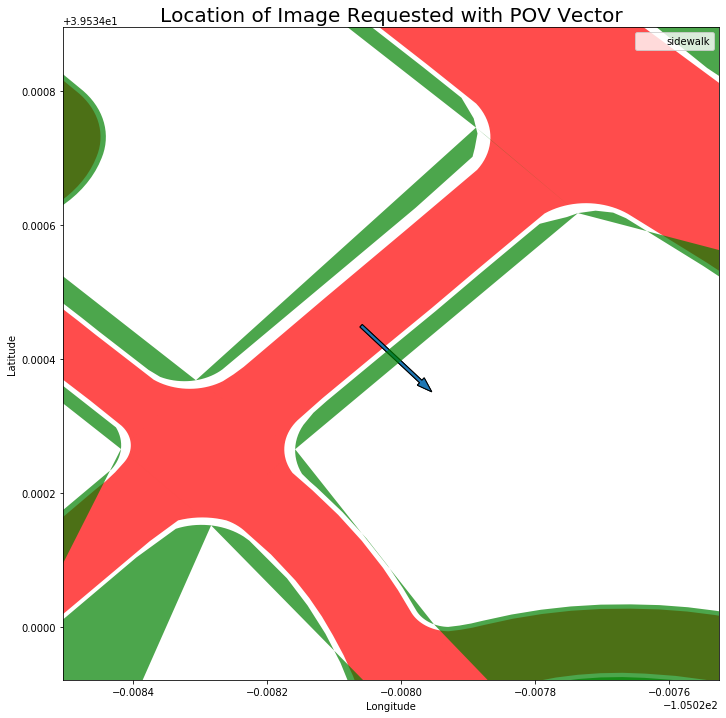

In [356]:
image_grab.download_images(show_image=True)

In [357]:
image_grab.Head

140.36566890055946

In [212]:
#investigate individual points
def location_checker(Lat=Lat, Lon=Lon, Head=Head):
    dx, dy = -0.00010834599480347151, 8.278524822458166e-05
    geod = pyproj.Geod(ellps='WGS84')
    Lon2, Lat2, _ = geod.fwd(lons=Lon, lats=Lat, az=Head, dist=13, radians=False)
    xrange = sorted([Lon, Lon2])
    yrange = sorted([Lat, Lat2])
    xrange = [xrange[0] - 3*dx, xrange[1] + 3*dx]
    yrange = [yrange[0] - 3*dy, yrange[1] + 3*dy]

    fig, ax = plt.subplots(figsize = (12,12))
    sidewalk_gdf.geometry.plot(facecolor='g', linewidth=0, edgecolor='g', alpha=0.8, ax=ax)
    arrow = plt.arrow(x=Lon, y=Lat, dx=dx, dy=dy, width=.000005)
    ax.add_patch(arrow)
    ax.set_xlim(*xrange)
    ax.set_ylim(*yrange)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Location of Image Requested', fontsize=20)
    plt.plot();

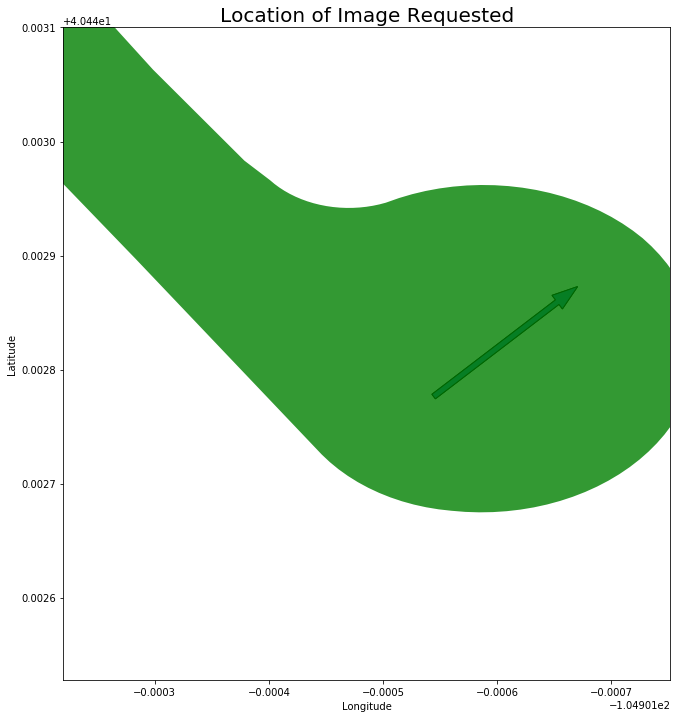

In [167]:
Lat, Lon = 40.4427764, -104.9015445
Head = 50
dx, dy = -0.00010834599480347151, 8.278524822458166e-05
location_checker()

In [ ]:
location_checker(Lat=Lat, Lon=Lon, Head=Head)

In [ ]:
Lat, Lon = 40.4427764, -104.9015445
Head = 50
dx, dy = -0.00010834599480347151, 8.278524822458166e-05
location_checker()

find if rand point is in a polygon
    find nearest polygon
    test for within
find angle
    create linear ring
    find nearest point
    determine angle of line with nearest pnt and original

### Plotting Data

In [ ]:
CO_cnty_lines_url = r'https://opendata.arcgis.com/datasets/66c2642209684b90af84afcc559a5a02_5.kml?outSR=%7B%22latestWkid%22%3A4269%2C%22wkid%22%3A4269%7D'
# data sourced from https://data-cdphe.opendata.arcgis.com/datasets/66c2642209684b90af84afcc559a5a02_5
!curl -o CO_county_lines.kml $CO_cnty_lines_url

In [18]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
CO_county_lines_gdf = gpd.read_file('CO_county_lines.kml', driver='KML')

In [19]:
CO_county_lines_gdf.head()

,Name,Description,geometry
0,,,"POLYGON ((-105.05673 40.34929, -105.05664 40.3..."
1,,,"POLYGON ((-104.14319 37.75834, -104.14408 37.7..."
2,,,"POLYGON ((-105.36890 38.25941, -105.36889 38.2..."
3,,,"POLYGON ((-106.79970 38.97966, -106.80041 38.9..."
4,,,"POLYGON ((-106.14888 37.40111, -106.15066 37.4..."


In [20]:
CO_county_lines_gdf.geometry.crs

{'init': 'epsg:4326'}

 metadata from https://gis.drcog.org/rdc/xml/planimetrics_2016_centerline_sidewalks.xml

In [21]:
CO_county_lines_gdf.geometry.crs = {'init': 'epsg:4326'}

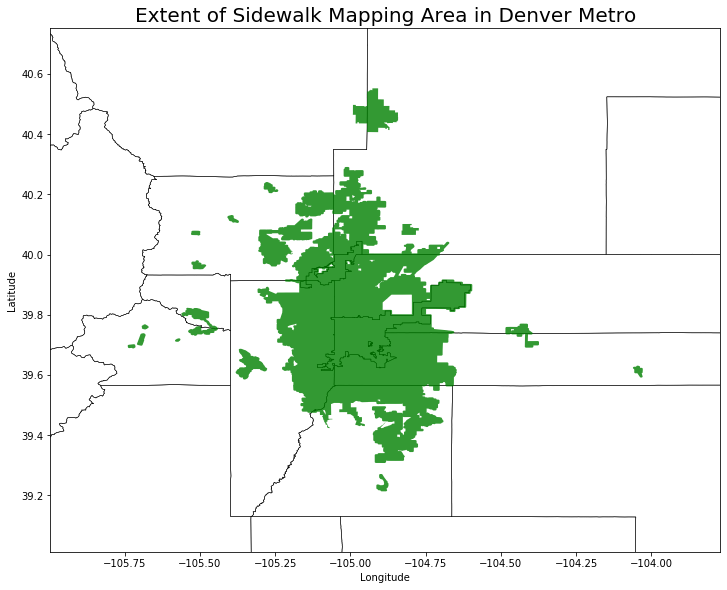

In [22]:
#establish boundaries
minx, miny, maxx, maxy = sidewalk_extent_gdf.geometry.total_bounds
xdiff = maxx - minx
ydiff = maxy - miny
maxx += .15*xdiff
minx -= .15*xdiff
maxy += .15*ydiff
miny -= .15*ydiff

#plot geometries
fig, ax = plt.subplots(figsize = (12,12))
CO_county_lines_gdf.geometry.plot(facecolor='none', linewidth=.5, edgecolor='k', ax=ax)
sidewalk_extent_gdf.geometry.plot(facecolor='g', linewidth=0, edgecolor='g', alpha=0.8, ax=ax)

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Extent of Sidewalk Mapping Area in Denver Metro', fontsize=20)
plt.plot();

#### denver roads shapefile
roads_url = https://koordinates.com/layer/101991-denver-colorado-street-centerline/  
requires koordinates login to download

In [ ]:
!unzip 'kx-denver-colorado-street-centerline-SHP.zip'

In [23]:
denver_streets_gdf = gpd.read_file('denver-colorado-street-centerline.shp')

In [24]:
denver_streets_gdf.head()

,FNODE,TNODE,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,PREFIX,...,T_ZLEV,ADMINCLASS,LRSROUTE,LRSCOMMENT,LRSBGN,LRSEND,HUNDBLKNAM,LRSMAJ,SHAPE_Leng,geometry
0,7833,7659,225.0,18944,20170608,561.0,599.0,560.0,598.0,N,...,0,2,ROSLYN ST7,LL,189.096668,371.004124,None,None,0.000477,"LINESTRING (-104.90097 39.72508, -104.90096 39..."
1,17472,17471,1607.0,27495,20170612,2851.0,2949.0,2850.0,2948.0,N,...,0,2,IOLA ST,LL,1003.936285,1492.316125,2850 BLK OF N IOLA ST,None,0.001341,"LINESTRING (-104.86455 39.75750, -104.86453 39..."
2,6163,6077,585.0,16501,20171024,400.0,498.0,401.0,499.0,None,...,0,2,13TH ST2,LR,142.786524,487.322780,400 BLK OF 13TH ST,None,0.001102,"LINESTRING (-104.99318 39.74039, -104.99360 39..."
3,6615,6465,402.0,4383,20020930,1301.0,1399.0,1300.0,1398.0,N,...,0,2,TENNYSON ST2,LR,458.896668,1124.667485,1300 BLK OF N TENNYSON ST,TENNYSON ST2 37,0.001828,"LINESTRING (-105.04400 39.73665, -105.04400 39..."
4,10731,10652,874.0,6514,20171024,2000.0,2098.0,2001.0,2099.0,W,...,0,2,WTENNESSEAV5,UR,1701.626782,1962.379486,2000 BLK OF W TENNESSEE AVE,None,0.000868,"LINESTRING (-105.01262 39.69832, -105.01299 39..."


In [25]:
denver_streets_gdf.geometry.crs

{'init': 'epsg:4326'}

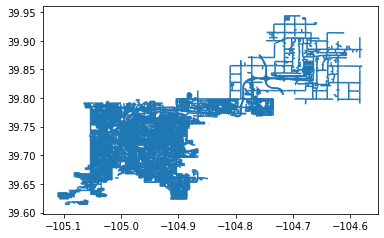

In [26]:
denver_streets_gdf.geometry.plot()

In [ ]:
#data source: https://data.drcog.org/dataset/edge-of-pavement-lines-2016


In [ ]:
image detection